# Project S4 - Building a single cell model from Allen Database in BMTK

### Goals
1. 1.	Continuing to learn to use APIs – You have used the following APIs so far: ```CellTypesApi``` and ```RmaApi```. In this project you will use the  ```BiophysicalApi``` to download a biophysical NEURON model from Allen database.
2. 2.	Learning how to model single neurons using BMTK - Build a single cell model in BMTK, simulate current clamp experiment, and compare electrophysiology features with experimental data.

### Introduction
The Allen Cell Types Database contains biophysical models that characterize the firing behavior of neurons measured in slices through current injection by a somatic whole-cell patch clamp electrode.  
The biophysical models are run with the NEURON simulation environment. The Allen SDK package contains libraries that assist in downloading and setting up the models available on the Allen Institute web site for users to run using NEURON. The examples and scripts provided run __on Linux__ using the bash shell.

It is recommended that you run the model on the __Virtual Machine__.

__Some useful links to the Allen website:__  
&emsp;__[Introduction to Biophysical Models](https://allensdk.readthedocs.io/en/latest/biophysical_models.html)__  
&emsp;__[Cell Type Database](http://celltypes.brain-map.org/)__   
&emsp;__[Example jupyter notebook - Stimulating a biophysical model with a square pulse](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/pulse_stimulus.html)__ 

### Procedure
#### 1. Download a biophysical NEURON model.
There are two ways to download files necessary to run a biophysical model. The first way is to visit __[Cell Type Database](http://celltypes.brain-map.org/)__ and find cells that have biophysical models available for download (See the Venn diagrams). The electrophysiology details page for a cell has a neuronal model download link. Specifically:

&emsp;Click ‘Select neuronal model’  
&emsp;Check Models -> ‘Biophysical - perisomatic’ or ‘Biophysical - all active’   
&emsp;Scroll down and click the ‘Biophysical - perisomatic’ or ‘Biophysical - all active’ ‘Download model’ link.

The second way is to programmatically download it using API. The neuronal model id can be found to the left of the corresponding ‘Biophysical - perisomatic’ or ‘Biophysical - all active’ ‘Download model’ link.  
We will adopt the second way to download the files using the following codes adapted from the example juptyer notebook given in the links.

Download model files according to the __model id__ which is not the same as __specimen id__,

In [ ]:
from allensdk.api.queries.biophysical_api import BiophysicalApi

neuronal_model_id = 472451419    # get this from the web site
model_directory = './source/'    # the files will be downloaded to the 'source' folder under current directory

bp = BiophysicalApi('http://api.brain-map.org')
bp.cache_stimulus = False # don't want to download the large stimulus NWB file
bp.cache_data(neuronal_model_id, working_directory=model_directory)

#### 2. Check cell information and electrophysiology features.
After downloading is done, the __specimen id__ can be found in the file name of xxxxxx_fit.json which contains biophysical model parameters.  
For this example, it is 386049446. Use the API to access the Cell Type Database to see the cell information and its electrophysiology features from biological recordings as you did in Project S3-2.

In [ ]:
from allensdk.api.queries.cell_types_api import CellTypesApi
cta = CellTypesApi() # the CellTypesApi instance
cell = cta.get_cell(386049446)
cell

In [ ]:
from allensdk.api.queries.rma_api import RmaApi
rma = RmaApi() # the RmaApi instance
data = rma.model_query(model='EphysFeature',criteria='[specimen_id$eq386049446]')[0]
data

#### 3. Simulate in NEURON (from the example notebook)
The following part runs a simulation with a current clamp using NEURON (Only runs in __Linux__. Use the __VM__ to run it).

In [ ]:
# based on allensdk.model.biophysical.biophysical_perisomatic.runner

# These will be useful for accessing and configuring the downloaded model
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

# not using NwbDataSet
# from allensdk.core.nwb_data_set import NwbDataSet

# We'll save results to a simple text file instead
from allensdk.core.dat_utilities import DatUtilities

import os
cwd = os.getcwd()

Compile modfiles in 'source' folder.

In [4]:
os.chdir('source')
print(os.system('nrnivmodl modfiles')) # compile modfiles. Return 0 for success, 1 for failure.
os.chdir(cwd)

0


Set up model configurations.

In [ ]:
os.chdir('source')

description = Config().load('manifest.json')
utils = Utils(description)
h = utils.h # NEURON handle

# configure model
manifest = description.manifest
morphology_path = description.manifest.get_path('MORPHOLOGY')
utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
utils.load_cell_parameters()

os.chdir(cwd)

At this point the cell model has been fully set up in NEURON.

Configure a simple current-clamp stimulus to generate some spikes.

In [ ]:
stim = h.IClamp(h.soma[0](0.5))
stim.amp = 0.18  # nA
stim.delay = 500.0
stim.dur = 1000.0

h.tstop = 2000.0

In [ ]:
vec = utils.record_values()

In [7]:
h.finitialize()
h.run()

0.0

Save the result to a simple time and voltage space-separated text file.

In [ ]:
import numpy

output_path = './source/output_voltage.dat'

junction_potential = description.data['fitting'][0]['junction_potential']
mV = 1.0e-3
ms = 1.0e-3

output_data = (numpy.array(vec['v']) - junction_potential) * mV
output_times = numpy.array(vec['t']) * ms

data = numpy.transpose(numpy.vstack((output_times, output_data)))
with open (output_path, "w") as f:
    numpy.savetxt(f, data)

Plot membrane voltage trace.

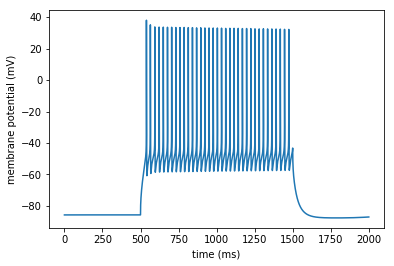

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(vec['t'], numpy.array(vec['v']) - junction_potential)
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)')
plt.show()

#### 4. Build a single cell model in BMTK using downloaded files.
Check the example notebook ```01_single_cell_clamped_S4.ipynb``` adapted from the BMTK tutorial 01.

### Details of Tasks
1. Download a perisomatic model with __model_id = 485591806__ or choose another cell that has biophysical model available from the Allen Cell Type database website.
2. Then build the single cell model with current clamp in BMTK.
3. Simulate with different current amplitudes and find out the threshold for the neuron to spike. Compare the threshold you find with the ```threshold_i_long_square```(unit: pA) given in the electrophysiology features from biological recordings.
4. You can also compare other features if you are interested (Optional). Check __[electrophysiology overview technical whitepaper](http://help.brain-map.org/download/attachments/8323525/CellTypes_Ephys_Overview.pdf)__ to see how the electrophysiology features are quantified.
5. Finally, in your own words, describe what you learned from this project. Also, comment on what can be improved in the project.